# Coursera/IBM 
# Applied Data Science Capstone Project 
## The Battle of Neighborhoods: Opening an Italian Restaurant in Paris


*****

## Table of contents
* [Introduction: Project & Background](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results & Discussion](#results)
* [Conclusions](#conclusions)

******

## Introduction: Project & Background <a name="introduction"></a>

In this Notebook, we'll attempt to find the best suggestions of locations to open an Italian Restaurant in Paris.

Of course, this is no easy task and the final decision should be made after further on-site investigation, but with some data we can already reduce the area to check to a handful of locations.

This analysis will be based on the following assumptions:

- Areas in which the restaurant density is very low will not be considered as good spots: indeed, if one could assume that they represent a gap to fill (which might be true!) they are most likely empty for a reason - e.g. prohibitive prices, protected or historical areas, etc.


- It is better to open an italian restaurant in neighborhoods where Italian Restaurants are among the most popular as this implies a demand for this type of food.

- However the new italian restaurant should be as far as possible from the existing ones as clients might prefer the venues they are used to.


- Even though french and italian cuisines are very distinct, they are usually enjoyed in a similar way: both french and italian food lovers will tend to sit for quite a while, taking their time to enjoy a good meal, as opposed to other types of food that can be enjoyed on the go. As a consequence, we will favour areas with many french restaurants, as they will mainly attract clients that would enjoy italian food as well.




******
## Data <a name="data"></a>

For this analysis, we will need to get data regarding Paris' arrondissements (i.e. neighborhoods):
- their shape
- their center

This will allow us to map our findings, gather data on nearby venues and frame potential clusters.

Then we will get data on parisian venues, that is:
- their name
- their coordinates
- the category they belong to

Finally we'll create a ```paris_restaurants``` dataframe with all we need for the analysis

### Getting a map of Paris' <i> Arrondissements </i>

A copy of the GeoJSON file we use is stored in the same repository as this notebook.


The original file can be found on the following page:
https://opendata.paris.fr/explore/dataset/arrondissements/export/?disjunctive.c_ar&disjunctive.c_arinsee&disjunctive.l_ar&location=13,48.85156,2.32327

In [1]:
import json

geo = json.load(open("/arrondissements.geojson"))

From this dataset, we can actually easily plot the shape of each <i>arrondissement</i> (i.e. neighborhood)

In [2]:
import folium
paris_choropleth = folium.Map(location = [48.856578, 2.351828], zoom_start = 12)
paris_choropleth.choropleth(geo_data = geo,fill_opacity=0.3,fill_color='blue')
paris_choropleth

But in order to request data about parisian venues, we will need to get the coordinates of the center of each neighborhood:

In [3]:
import pandas as pd

paris_ardt = []
for arr in geo["features"]:
    prop = arr["properties"]
    paris_ardt.append([prop["l_ar"].split('è')[0].split('e')[0],prop["geom_x_y"][0],prop["geom_x_y"][1]])
paris_ardt_df= pd.DataFrame(paris_ardt,columns=['Ardt','Latitude','Longitude'])
paris_ardt_df['Ardt'] = paris_ardt_df['Ardt'].astype(int)
paris_ardt_df.sort_values('Ardt',inplace=True)
paris_ardt_df = paris_ardt_df.reset_index().drop('index',axis=1)
paris_ardt_df

Ardt   Latitude  Longitude
0      1  48.862563   2.336443
1      2  48.868279   2.342803
2      3  48.862872   2.360001
3      4  48.854341   2.357630
4      5  48.844443   2.350715
5      6  48.849130   2.332898
6      7  48.856174   2.312188
7      8  48.872721   2.312554
8      9  48.877164   2.337458
9     10  48.876130   2.360728
10    11  48.859059   2.380058
11    12  48.834974   2.421325
12    13  48.828388   2.362272
13    14  48.829245   2.326542
14    15  48.840085   2.292826
15    16  48.860392   2.261971
16    17  48.887327   2.306777
17    18  48.892569   2.348161
18    19  48.887076   2.384821
19    20  48.863461   2.401188

Which we can add to the previous map...

In [4]:
for ardt, lat, lng in zip(paris_ardt_df['Ardt'], paris_ardt_df['Latitude'], paris_ardt_df['Longitude']):
    label = folium.Popup("Ardt n°"+ str(ardt), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='black',
        parse_html=False).add_to(paris_choropleth)

paris_choropleth



We can see however that the centers of the 12th and 16th neighborhood are quite off, as they account for large parks - so we will correct them as follows:


In [5]:
corrections = [
    [12, 48.841, 2.388],
    [16, 48.863, 2.276]
]

corrections_df = pd.DataFrame(corrections,columns=['Ardt','Latitude','Longitude'])
paris_ardt_df = paris_ardt_df.append(corrections_df).drop_duplicates('Ardt',keep='last').sort_values('Ardt',ignore_index=True)

In [6]:
paris_choropleth = folium.Map(location = [48.856578, 2.351828], zoom_start = 12)
paris_choropleth.choropleth(geo_data = geo,fill_opacity=0.3,fill_color='blue')
paris_choropleth

for ardt, lat, lng in zip(paris_ardt_df['Ardt'], paris_ardt_df['Latitude'], paris_ardt_df['Longitude']):
    label = folium.Popup("Ardt n°"+ str(ardt), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='black',
        parse_html=False).add_to(paris_choropleth)

#adding markers using previous coordinates...
folium.CircleMarker(
        [48.834974, 2.421325],
        radius=2,
        color='red',
        parse_html=False).add_to(paris_choropleth)
folium.CircleMarker(
        [48.860392, 2.261971],
        radius=2,
        color='red',
        parse_html=False).add_to(paris_choropleth)



paris_choropleth

Looks much better !

### Downloading Venues' data using the FourSquare API

Now that we have the coordinates of the center of each neighborhood, we will use them to get data related to the nearby venues using the FourSquare API: 

- First, will need to input our FourSquare credentials

In [7]:
CLIENT_ID = '################' # your Foursquare ID
CLIENT_SECRET = '################' # your Foursquare Secret
ACCESS_TOKEN = '################' # your FourSquare Access Token
#VERSION = '20180604'
VERSION = '20210411'
LIMIT = 100


- then we'll create a function to actually request the data for each neighborhood and store it in a dataframe

In [8]:
import requests

def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('Ardt ' + str(name) + ' : Getting data...')
            
        # creating the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # returning only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        print('Done'+'\n')

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

- once it's done, we can use the function with the neighborhood centers that we defined above:

In [9]:
paris_venues = getNearbyVenues(names=paris_ardt_df['Ardt'],
                                   latitudes=paris_ardt_df['Latitude'],
                                   longitudes=paris_ardt_df['Longitude'],
                                   radius=1750
                                  )

Ardt 1 : Getting data...
Done

Ardt 2 : Getting data...
Done

Ardt 3 : Getting data...
Done

Ardt 4 : Getting data...
Done

Ardt 5 : Getting data...
Done

Ardt 6 : Getting data...
Done

Ardt 7 : Getting data...
Done

Ardt 8 : Getting data...
Done

Ardt 9 : Getting data...
Done

Ardt 10 : Getting data...
Done

Ardt 11 : Getting data...
Done

Ardt 12 : Getting data...
Done

Ardt 13 : Getting data...
Done

Ardt 14 : Getting data...
Done

Ardt 15 : Getting data...
Done

Ardt 16 : Getting data...
Done

Ardt 17 : Getting data...
Done

Ardt 18 : Getting data...
Done

Ardt 19 : Getting data...
Done

Ardt 20 : Getting data...
Done



- this has collected data for all categories of venues, so we will create a dataframe that only includes restaurants:

In [10]:
# Keeping only restaurants
paris_restaurants = paris_venues[paris_venues['Venue Category'].str.contains("Restaurant")]
paris_restaurants.shape

(650, 7)

Now, as we have collected data based on the proximity of each venue to the center of each neighborhood ('<i>Arrondissement</i>' in french), we happen to have duplicates in our dataframe...

In [11]:
paris_restaurants.groupby(['Venue','Venue Latitude','Venue Longitude']).count().sort_values("Neighborhood",ascending=False).head()

Neighborhood  \
Venue                     Venue Latitude Venue Longitude                 
Raviolis Chinois Nord-Est 48.862851      2.349547                    4   
Foodi Jia-Ba-Buay         48.867894      2.348266                    4   
Taing Song-Heng           48.864701      2.356888                    4   
Chez Le Libanais          48.853285      2.341673                    4   
Man'ouché                 48.861858      2.351093                    4   

                                                          Neighborhood Latitude  \
Venue                     Venue Latitude Venue Longitude                          
Raviolis Chinois Nord-Est 48.862851      2.349547                             4   
Foodi Jia-Ba-Buay         48.867894      2.348266                             4   
Taing Song-Heng           48.864701      2.356888                             4   
Chez Le Libanais          48.853285      2.341673                             4   
Man'ouché                 48.861858      2.351093                             4   

                                                          Neighborhood Longitude  \
Venue                     Venue Latitude Venue Longitude                           
Raviolis Chinois Nord-Est 48.862851      2.349547                              4   
Foodi Jia-Ba-Buay         48.867894      2.348266                              4   
Taing Song-Heng           48.864701      2.356888                              4   
Chez Le Libanais          48.853285      2.341673                              4   
Man'ouché                 48.861858      2.351093                              4   

                                                          Venue Category  
Venue                     Venue Latitude Venue Longitude                  
Raviolis Chinois Nord-Est 48.862851      2.349547                      4  
Foodi Jia-Ba-Buay         48.867894      2.348266                      4  
Taing Song-Heng           48.864701      2.356888                      4  
Chez Le Libanais          48.853285      2.341673                      4  
Man'ouché                 48.861858      2.351093                      4

So our first task will be to 'clean' this dataframe by removing all these duplicates...

To do so, we'll calculate the distance of each venue from the center to each neighborhood and keep the one with the lowest value:

- So we start by generating a matrix which gives us for each venue its distance to the center of all Paris' neighborhoods (please note that ```Ardt``` stands for <i>Arrondissement</i>, or neighborhood)

In [12]:
import sklearn.neighbors
import numpy as np 

# generating radians 
paris_ardt_df[['lat_radians_A','long_radians_A']] = (
    np.radians(paris_ardt_df.loc[:,['Latitude','Longitude']])
)

paris_restaurants[['lat_radians_B','long_radians_B']] = (
    np.radians(paris_restaurants.loc[:,['Venue Latitude','Venue Longitude']])
)

# calculating the distances using the Haversine formula
dist = sklearn.neighbors.DistanceMetric.get_metric('haversine')

dist_matrix_center = (dist.pairwise
    (paris_restaurants[['lat_radians_B','long_radians_B']],
        paris_ardt_df[['lat_radians_A','long_radians_A']])*6371
)
# Note that 6371 is the radius of the earth in kilometers

df_dist_center_matrix = (
    pd.DataFrame(dist_matrix_center,index=paris_restaurants['Venue'],
                 columns=paris_ardt_df['Ardt'])
)

df_dist_center_matrix['Ardt'] = df_dist_center_matrix.idxmin(axis=1)

df_dist_center_matrix

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Ardt                          1         2         3         4         5  \
Venue                                                                     
Sanukiya               0.307293  0.768340  1.927121  2.089930  2.571143   
Restaurant Kunitoraya  0.395082  0.522141  1.758858  2.027537  2.625663   
Boutique yam'Tcha      0.444513  0.731135  1.295473  1.384174  2.014482   
Enza & Famiglia        0.534675  0.789590  1.225187  1.287015  1.936670   
Au Vieux Comptoir      0.817624  1.071672  1.107074  0.981898  1.641425   
...                         ...       ...       ...       ...       ...   
Khun Akorn             4.724190  4.534347  3.140741  2.997939  3.509612   
Café Lino              4.440884  4.178482  2.788728  2.795951  3.480619   
La Petite Fabrique     4.678842  4.418760  3.029087  3.022655  3.671422   
Les Mondes Bohèmes     4.710890  4.445521  3.056969  3.059739  3.713847   
Aux Deux Avenues       5.834271  5.410390  4.111458  4.373991  5.184041   

Ardt                          6         7         8         9        10  ...  \
Venue                                                                    ...   
Sanukiya               1.734015  1.844557  1.791325  1.409938  2.342911  ...   
Restaurant Kunitoraya  1.906649  2.092016  1.896974  1.230593  2.094925  ...   
Boutique yam'Tcha      1.561353  2.292932  2.501703  1.755683  2.090969  ...   
Enza & Famiglia        1.547370  2.354014  2.598143  1.829322  2.087299  ...   
Au Vieux Comptoir      1.454484  2.501427  2.897499  2.128276  2.194071  ...   
...                         ...       ...       ...       ...       ...  ...   
Khun Akorn             4.763998  6.319249  6.753254  5.377632  4.006405  ...   
Café Lino              4.641880  6.123943  6.426529  4.968183  3.531383  ...   
La Petite Fabrique     4.856581  6.352607  6.666795  5.204698  3.753644  ...   
Les Mondes Bohèmes     4.896352  6.389219  6.695335  5.225984  3.766829  ...   
Aux Deux Avenues       6.266474  7.638916  7.669853  5.993173  4.340817  ...   

Ardt                         12        13        14        15         16  \
Venue                                                                      
Sanukiya               4.761886  4.544699  3.979599  4.060695   4.232715   
Restaurant Kunitoraya  4.692050  4.600516  4.163717  4.309657   4.436618   
Boutique yam'Tcha      4.055209  3.980905  3.791460  4.350663   4.857939   
Enza & Famiglia        3.958101  3.898958  3.761564  4.384910   4.938120   
Au Vieux Comptoir      3.653076  3.591853  3.594883  4.425529   5.150478   
...                         ...       ...       ...       ...        ...   
Khun Akorn             1.215570  3.531021  5.704168  7.770685   9.046721   
Café Lino              1.590155  3.789649  5.788497  7.703053   8.820271   
La Petite Fabrique     1.612060  3.879177  5.948873  7.907768   9.053758   
Les Mondes Bohèmes     1.650449  3.921512  5.992649  7.949007   9.088556   
Aux Deux Avenues       3.136748  5.454148  7.517332  9.357259  10.255999   

Ardt                         17        18        19        20  Ardt  
Venue                                                                
Sanukiya               3.198376  3.270502  4.483616  4.930985     1  
Restaurant Kunitoraya  3.205776  3.063274  4.235165  4.743442     1  
Boutique yam'Tcha      3.859194  3.457352  4.194022  4.306303     1  
Enza & Famiglia        3.954562  3.506077  4.176077  4.231280     1  
Au Vieux Comptoir      4.275408  3.747561  4.222372  4.059680     1  
...                         ...       ...       ...       ...   ...  
Khun Akorn             7.873810  5.998258  4.263167  1.544565    12  
Café Lino              7.476204  5.498695  3.728699  1.087272    20  
La Petite Fabrique     7.713582  5.707269  3.863919  1.110106    20  
Les Mondes Bohèmes     7.735574  5.714780  3.852468  1.082732    20  
Aux Deux Avenues       8.474267  6.010241  3.589837  1.106202    20  

[650 rows x 21 columns]

In [13]:
venue_ardt = df_dist_center_matrix[['Ardt']].reset_index()
venue_ardt.drop_duplicates(subset=['Venue'],inplace=True)

paris_restaurants = pd.merge(paris_restaurants, venue_ardt, on=['Venue'], how='inner')
paris_restaurants = paris_restaurants.drop(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','lat_radians_B','long_radians_B'],axis=1).drop_duplicates(subset='Venue')
paris_restaurants.head()


Venue  Venue Latitude  Venue Longitude  \
0               Sanukiya       48.864713         2.333805   
2  Restaurant Kunitoraya       48.866116         2.336467   
5      Boutique yam'Tcha       48.861710         2.342380   
7        Enza & Famiglia       48.861191         2.343449   
9      Au Vieux Comptoir       48.858893         2.346129   

        Venue Category  Ardt  
0      Udon Restaurant     1  
2  Japanese Restaurant     1  
5   Chinese Restaurant     1  
7   Italian Restaurant     1  
9    French Restaurant     1

In [14]:
# No more duplicates...

paris_restaurants.groupby(['Venue','Venue Latitude','Venue Longitude']).count().sort_values("Ardt",ascending=False).head(5)

Venue Category  Ardt
Venue                Venue Latitude Venue Longitude                      
0 d'Attente          48.837847      2.355120                      1     1
Le Temps des Cerises 48.852554      2.364195                      1     1
Les Fauves           48.841937      2.322581                      1     1
Les Chics Types      48.883873      2.380440                      1     1
Les Canailles        48.879281      2.334570                      1     1

We can now plot all restaurants on the map to check if the venues in the dataset are indeed included within the right neighborhood

In [15]:
paris = folium.Map(location = [48.856578, 2.351828], zoom_start = 12)

import matplotlib.cm as cm
import matplotlib.colors as colors

x = np.arange(20) # There are 20 neighbohoods in Paris
ys = [i + x + (i*x)**2 for i in range(20)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

paris.choropleth(geo_data = geo,fill_opacity=0.3,fill_color='black')
for lat, lng, label, ardt in zip(paris_restaurants['Venue Latitude'], paris_restaurants['Venue Longitude'], paris_restaurants['Venue'],paris_restaurants['Ardt']):
    label = folium.Popup(label + " ("+ str(ardt) +")", parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color=rainbow[ardt-1],
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(paris)

for ardt, lat, lng in zip(paris_ardt_df['Ardt'], paris_ardt_df['Latitude'], paris_ardt_df['Longitude']):
    label = folium.Popup("Ardt n°"+ str(ardt), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='black',
        parse_html=False).add_to(paris)
    
paris

That looks about right! The data is almost ready to be analyzed!


We'll now take care of the ```Venue Category``` values:
- First, we'll replace <i>Restaurant</i> by <i>Unspecified</i>  in ```paris_restaurants['Venue Category']```

In [16]:
paris_restaurants.loc[paris_restaurants['Venue Category']=='Restaurant'] = paris_restaurants.loc[paris_restaurants['Venue Category']=='Restaurant'].replace('Restaurant','Unspecified')
paris_restaurants.groupby(['Venue Category']).count().sort_values('Venue',ascending=False).drop(['Venue Latitude','Venue Longitude','Ardt'],axis=1).head()

Venue
Venue Category            
French Restaurant      192
Italian Restaurant      46
Japanese Restaurant     31
Unspecified             24
Thai Restaurant         20

- Then we will attribute a unique identifier to each category:

In [17]:
paris_restaurants.insert(4,'code',(pd.factorize(paris_restaurants['Venue Category'])[0]+1))
paris_restaurants.groupby(['Venue Category','code']).count().sort_values('Venue',ascending=False).drop(['Venue Latitude','Venue Longitude','Ardt'],axis=1).head()

Venue
Venue Category      code       
French Restaurant   5       192
Italian Restaurant  4        46
Japanese Restaurant 2        31
Unspecified         6        24
Thai Restaurant     14       20

- Finally, from this cleaned dataframe, we can plot the restaurants on the map with colors based on the category they belong to:

In [18]:
paris_cat = folium.Map(location = [48.856578, 2.351828], zoom_start = 12)

import matplotlib.cm as cm
import matplotlib.colors as colors

nb_cat = len(paris_restaurants.groupby(['code']))

x = np.arange(nb_cat)
ys = [i + x + (i*x)**2 for i in range(nb_cat)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

paris_cat.choropleth(geo_data = geo,fill_opacity=0.25,fill_color='blue')
for lat, lng, label, cat , group in zip(paris_restaurants['Venue Latitude'], paris_restaurants['Venue Longitude'], paris_restaurants['Venue'],paris_restaurants['code'], paris_restaurants['Venue Category']):
    label = folium.Popup(label + " (" + group + ") [" + str(ardt)+ "]", parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color=rainbow[cat-1],
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(paris_cat)

for ardt, lat, lng in zip(paris_ardt_df['Ardt'], paris_ardt_df['Latitude'], paris_ardt_df['Longitude']):
    label = folium.Popup("Ardt n°"+ str(ardt), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='black',
        parse_html=False).add_to(paris_cat)
    
paris_cat

****
## Methodology <a name="methodology"></a>

In order to define where would be the best spots to open an italian restaurant in Paris, we will take the following steps:

<b> 1. Verifying our assumptions  </b>
- Basic analysis of the data
- Compare popularity of french vs. italian restaurants for each neighborhood

<b> 2. Density Analyses  </b>
- Mapping neighborhoods with an <i>italian restaurants deficit</i>
- Mapping venue densities for french and italiantrestaurants
- Isolating french restaurants that are far from italian restaurants


<b> 3. Clustering & Cross-checking </b>
- Creating clusters using k-means
- Superimposing the analyses
- Listing of the results

*****
## Analysis  <a name="analysis"></a>

### 1. Verifying our assumptions

In [19]:
paris_restaurants.groupby('Venue Category').nunique().sort_values('Venue',ascending=False).drop(['Venue Latitude','Venue Longitude','Venue Category','code'],axis=1).head()


Venue  Ardt
Venue Category                  
French Restaurant      192    20
Italian Restaurant      46    20
Japanese Restaurant     31    17
Unspecified             24    14
Thai Restaurant         20     9

From the above table, we can see that the ```Venue Category``` <i>Italian Restaurants</i> is not only the second best in Paris in terms of number of venues, but also that it is <b>the only non-french category that is present in all of the 20 parisian neighborhoods</b>.

#### Getting Most common value per neighborhood

In [20]:
paris_onehot = pd.get_dummies(paris_restaurants[['Venue Category']], prefix="", prefix_sep="")
paris_onehot['Ardt'] = paris_restaurants['Ardt']
paris_grouped = paris_onehot.groupby('Ardt',axis=0).mean().reset_index()

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
import numpy as np

num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Ardt']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Ardt'] = paris_grouped['Ardt']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

Ardt  1st Most Common Venue  2nd Most Common Venue  \
0      1      French Restaurant    Japanese Restaurant   
1      2    Japanese Restaurant      French Restaurant   
2      3            Unspecified  Vietnamese Restaurant   
3      4      French Restaurant    Japanese Restaurant   
4      5      French Restaurant     Italian Restaurant   
5      6      French Restaurant     Italian Restaurant   
6      7      French Restaurant    Japanese Restaurant   
7      8      French Restaurant     Italian Restaurant   
8      9      French Restaurant     Italian Restaurant   
9     10      French Restaurant    Japanese Restaurant   
10    11      French Restaurant            Unspecified   
11    12      French Restaurant        Thai Restaurant   
12    13  Vietnamese Restaurant        Thai Restaurant   
13    14      French Restaurant     Italian Restaurant   
14    15      French Restaurant    Japanese Restaurant   
15    16      French Restaurant     Italian Restaurant   
16    17      French Restaurant     Italian Restaurant   
17    18      French Restaurant    Japanese Restaurant   
18    19      French Restaurant    Japanese Restaurant   
19    20      French Restaurant    Japanese Restaurant   

      3rd Most Common Venue          4th Most Common Venue  \
0        Chinese Restaurant             Italian Restaurant   
1          Ramen Restaurant               Greek Restaurant   
2        Italian Restaurant             Seafood Restaurant   
3   Scandinavian Restaurant             Italian Restaurant   
4          Greek Restaurant             Chinese Restaurant   
5               Unspecified            Lebanese Restaurant   
6          Greek Restaurant             Italian Restaurant   
7       Japanese Restaurant                Thai Restaurant   
8       Japanese Restaurant  Vegetarian / Vegan Restaurant   
9           Thai Restaurant  Vegetarian / Vegan Restaurant   
10       Italian Restaurant          Vietnamese Restaurant   
11      Japanese Restaurant             Falafel Restaurant   
12        French Restaurant             Chinese Restaurant   
13    Vietnamese Restaurant  Vegetarian / Vegan Restaurant   
14      Lebanese Restaurant                    Unspecified   
15      Japanese Restaurant             Seafood Restaurant   
16              Unspecified             Turkish Restaurant   
17       Italian Restaurant               Arepa Restaurant   
18       Chinese Restaurant             Italian Restaurant   
19       Italian Restaurant            Moroccan Restaurant   

            5th Most Common Venue          6th Most Common Venue  \
0                 Udon Restaurant                    Unspecified   
1                Doner Restaurant            Corsican Restaurant   
2              Chinese Restaurant              French Restaurant   
3   Vegetarian / Vegan Restaurant             Falafel Restaurant   
4                 Thai Restaurant           Ethiopian Restaurant   
5              Seafood Restaurant             Mexican Restaurant   
6              Chinese Restaurant              Indian Restaurant   
7                Sushi Restaurant             Seafood Restaurant   
8                     Unspecified                Thai Restaurant   
9                     Unspecified             Chinese Restaurant   
10               Asian Restaurant            Moroccan Restaurant   
11             Seafood Restaurant             Chinese Restaurant   
12       Mediterranean Restaurant               Asian Restaurant   
13            Japanese Restaurant              Indian Restaurant   
14                Thai Restaurant             Italian Restaurant   
15      Middle Eastern Restaurant             Persian Restaurant   
16             Seafood Restaurant              Breton Restaurant   
17         Argentinian Restaurant               Greek Restaurant   
18                    Unspecified            Moroccan Restaurant   
19           Brazilian Restaurant  Vegetarian / Vegan Restaurant   

            7th Most Common Venue        8th Most Com

In [23]:
import plotly.express as px

selected_columns = neighborhoods_venues_sorted.columns[1:5]

fig_pc = px.parallel_categories(neighborhoods_venues_sorted,dimensions=selected_columns,height=500,width=800,color='Ardt')
fig_pc.show()


In [24]:
# Summarizing the above in plain english ...

print("\n")
print("Italian Restaurants:")
print("\n")

for i in range(1,5):
    
    if 'Italian Restaurant' in neighborhoods_venues_sorted[neighborhoods_venues_sorted.columns[i]].value_counts():
        print(str(neighborhoods_venues_sorted.columns[i]) + ' in ' + str(neighborhoods_venues_sorted[neighborhoods_venues_sorted.columns[i]].value_counts()['Italian Restaurant']) + ' neighborhoods.')
        print('>> namely : ' + str(
            neighborhoods_venues_sorted[neighborhoods_venues_sorted[neighborhoods_venues_sorted.columns[i]]=='Italian Restaurant']['Ardt'].tolist()
        ))
    else:
        print('Not the '+str(neighborhoods_venues_sorted.columns[i]) + ' in any neighborhood.')
    print("\n")



Italian Restaurants:


Not the 1st Most Common Venue in any neighborhood.


2nd Most Common Venue in 7 neighborhoods.
>> namely : [5, 6, 8, 9, 14, 16, 17]


3rd Most Common Venue in 4 neighborhoods.
>> namely : [3, 11, 18, 20]


4th Most Common Venue in 4 neighborhoods.
>> namely : [1, 4, 7, 19]




We will now create a table that will count the actual number of french and italian restaurants in each neighborhood.

In [25]:

group_by_cat = paris_restaurants.groupby(['Ardt','Venue Category']).count()[['Venue']].reset_index()
ardt_type = []
for i in range(20):
    ardt = i + 1
    fr_res = group_by_cat[group_by_cat['Ardt']==ardt][group_by_cat["Venue Category"]=="French Restaurant"]['Venue'].values[0]
    it_res = group_by_cat[group_by_cat['Ardt']==ardt][group_by_cat["Venue Category"]=="Italian Restaurant"]['Venue'].values[0]
    total = group_by_cat[group_by_cat['Ardt']==ardt]['Venue'].sum()
    ardt_type.append([ardt, fr_res, it_res, total, fr_res/total, it_res/total,it_res/fr_res])


ardt_type_df = pd.DataFrame(ardt_type,columns=['Ardt','nb_fr','nb_it','nb_tot','pct_fr','pct_it','it/fr']).sort_values('Ardt',ignore_index=True)

ardt_type_df


<ipython-input-25-422bac177c2f>:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-25-422bac177c2f>:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Ardt  nb_fr  nb_it  nb_tot    pct_fr    pct_it     it/fr
0      1      3      1       8  0.375000  0.125000  0.333333
1      2      3      1      13  0.230769  0.076923  0.333333
2      3      1      2      15  0.066667  0.133333  2.000000
3      4      5      1      12  0.416667  0.083333  0.200000
4      5      7      3      20  0.350000  0.150000  0.428571
5      6     10      3      27  0.370370  0.111111  0.300000
6      7     17      1      20  0.850000  0.050000  0.058824
7      8     17      4      28  0.607143  0.142857  0.235294
8      9     13      3      24  0.541667  0.125000  0.230769
9     10      7      1      34  0.205882  0.029412  0.142857
10    11     12      2      25  0.480000  0.080000  0.166667
11    12      5      1      15  0.333333  0.066667  0.200000
12    13      5      1      39  0.128205  0.025641  0.200000
13    14     20      5      39  0.512821  0.128205  0.250000
14    15     21      2      43  0.488372  0.046512  0.095238
15    16     12      7      27  0.444444  0.259259  0.583333
16    17     13      3      29  0.448276  0.103448  0.230769
17    18      2      1      10  0.200000  0.100000  0.500000
18    19     10      2      21  0.476190  0.095238  0.200000
19    20      9      2      24  0.375000  0.083333  0.222222

First, we'll plot the number of italian restaurants vs. the number of french restaurant and draw a regression line to confirm if these two are indeed positively correlated.

We will first create a 'clean' dataframe that will exclude outliers and then draw the regression line using Seaborn:

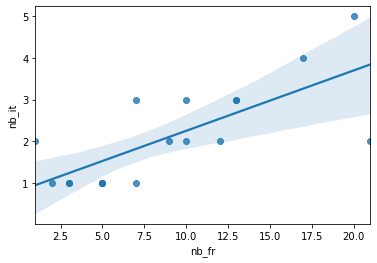

In [26]:
# Dropping outliers and drawing a regression line
ardt_type_df_clean = ardt_type_df.drop(ardt_type_df['pct_fr'].idxmax()).drop(ardt_type_df['pct_it'].idxmax())
import seaborn as sns
ax = sns.regplot(x="nb_fr", y="nb_it", data=ardt_type_df_clean)
ax

So there seems to be a positive correlation that confirms our previous assumption! i.e. that an area with many french restaurants will also be good for italian restaurants.

### 2. Density Analyses

Now we will take the number of italian/french restaurants and map it to see which aread have a 'deficit' of italian restaurants.

We'll attribute a 0/1 deficit label to each neighborhood, with 1 indicating that the share of italian restaurants is below the median.

In [27]:
it_deficit = ardt_type_df[['Ardt','it/fr']]
it_deficit['deficit'] = it_deficit['it/fr'] <= it_deficit['it/fr'].median()
it_deficit['deficit'] = it_deficit['deficit'].astype(int)
it_deficit

<ipython-input-27-da3ef5ae4330>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-27-da3ef5ae4330>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Ardt     it/fr  deficit
0      1  0.333333        0
1      2  0.333333        0
2      3  2.000000        0
3      4  0.200000        1
4      5  0.428571        0
5      6  0.300000        0
6      7  0.058824        1
7      8  0.235294        0
8      9  0.230769        1
9     10  0.142857        1
10    11  0.166667        1
11    12  0.200000        1
12    13  0.200000        1
13    14  0.250000        0
14    15  0.095238        1
15    16  0.583333        0
16    17  0.230769        1
17    18  0.500000        0
18    19  0.200000        1
19    20  0.222222        1

In [28]:
latitude = 48.856578
longitude = 2.351828

italian_deficit = folium.Map(location=[latitude, longitude], zoom_start=12)


italian_deficit.choropleth(geo_data = geo,key_on = "feature.properties.c_ar",data=it_deficit[it_deficit['deficit']==1],
                 columns = ['Ardt','deficit'],fill_color='RdYlGn',fill_opacity=0.5)


# adding markers to map

italian_deficit

The neighborhoods in green would be good candidates to welcome a new italian restaurant.

### Mapping densities

### Density of italian restaurants

In [29]:
from folium.plugins import HeatMap

italian = paris_restaurants[paris_restaurants['Venue Category']=='Italian Restaurant']
french = paris_restaurants[paris_restaurants['Venue Category']=='French Restaurant']

excluded = ['Italian Restaurant','French Restaurant']
others = paris_restaurants[~paris_restaurants['Venue Category'].isin(excluded)]

latitude = 48.856578
longitude = 2.351828


# Italian HeatMap

italian_coord = []
for index, row in italian.iterrows():
    italian_coord.append([row[1], row[2]])

map_density_it = folium.Map(location=[latitude, longitude], zoom_start=12)

HeatMap(italian_coord).add_to(map_density_it)

map_density_it.choropleth(geo_data = geo,fill_opacity=0)

for lat, lng, label in zip(italian['Venue Latitude'], italian['Venue Longitude'], italian['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_density_it)  
for lat, lng, label in zip(french['Venue Latitude'], french['Venue Longitude'], french['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='green',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_density_it)  
for lat, lng, label in zip(others['Venue Latitude'], others['Venue Longitude'], others['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='orange',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_density_it)  
for ardt, lat, lng in zip(paris_ardt_df['Ardt'], paris_ardt_df['Latitude'], paris_ardt_df['Longitude']):
    label = folium.Popup("Ardt n°"+ str(ardt), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='black',
        parse_html=False).add_to(map_density_it)
map_density_it

On the above map:
- french restaurants are in green (we want to be as close to them as possible), 
- italian restaurants are in red (we want to be as far from them as possible),
- other restaurants are in orange (we will not take them into account in this density analysis)

Now let's superimpose french and italian densities:

In [30]:

italian = paris_restaurants[paris_restaurants['Venue Category']=='Italian Restaurant']
french = paris_restaurants[paris_restaurants['Venue Category']=='French Restaurant']

excluded = ['Italian Restaurant','French Restaurant']
others = paris_restaurants[~paris_restaurants['Venue Category'].isin(excluded)]

latitude = 48.856578
longitude = 2.351828

italian_coord = []
for index, row in italian.iterrows():
    italian_coord.append([row[1], row[2]])

french_coord = []
for index, row in french.iterrows():
    french_coord.append([row[1], row[2]])


map_heat_fr_it = folium.Map(location=[latitude, longitude], zoom_start=12)

french_grad = {0.01: 'green', 1: 'green'}
italian_grad = {0.01: 'red', 1: 'red'}

HeatMap(french_coord, gradient = french_grad).add_to(map_heat_fr_it)
HeatMap(italian_coord,gradient = italian_grad).add_to(map_heat_fr_it)


map_heat_fr_it.choropleth(geo_data = geo,fill_opacity=0)

for lat, lng, label in zip(italian['Venue Latitude'], italian['Venue Longitude'], italian['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_heat_fr_it)  

for lat, lng, label in zip(french['Venue Latitude'], french['Venue Longitude'], french['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='green',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_heat_fr_it)  
 

for ardt, lat, lng in zip(paris_ardt_df['Ardt'], paris_ardt_df['Latitude'], paris_ardt_df['Longitude']):
    label = folium.Popup("Ardt n°"+ str(ardt), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='black',
        parse_html=False).add_to(map_heat_fr_it)

map_heat_fr_it

So we'll now isolate the green areas, by measuring the distances from each french venue to the closest italian restaurant and keeping only the one that are the farthest

First of all, we'll get the distance matrix using the Haversine formula with the help of Scikit-learn

In [31]:

import sklearn.neighbors

french_coord_df = french.reset_index().drop(['index','Ardt','code','Venue Category'],axis=1)
italian_coord_df = italian.reset_index().drop(['index','Ardt','code','Venue Category'],axis=1)


french_coord_df[['lat_radians_A','long_radians_A']] = (
    np.radians(french_coord_df.loc[:,['Venue Latitude','Venue Longitude']])
)
italian_coord_df[['lat_radians_B','long_radians_B']] = (
    np.radians(italian_coord_df.loc[:,['Venue Latitude','Venue Longitude']])
)

dist = sklearn.neighbors.DistanceMetric.get_metric('haversine')
dist_matrix = (dist.pairwise
    (french_coord_df[['lat_radians_A','long_radians_A']],
     italian_coord_df[['lat_radians_B','long_radians_B']])*6371
)
# Note that 3959 is the radius of the earth in miles

df_dist_matrix = (
    pd.DataFrame(dist_matrix,index=french_coord_df['Venue'], 
                 columns=italian_coord_df['Venue'])
)

df_dist_matrix['min_dist_it'] = df_dist_matrix.min(axis=1)
df_dist_matrix=df_dist_matrix.sort_values('min_dist_it',ascending=False)

df_dist_matrix

Venue                            Enza & Famiglia  L'Étage de Pastavino  \
Venue                                                                    
Les Pantins                             5.735030              6.638454   
Le Quinzième                            5.363588              4.644627   
Le Pré en Bulles – Chez Martine         4.988585              5.848713   
Aux Deux Avenues                        5.323087              5.879951   
La Grenouille Bleue                     5.273938              4.531769   
...                                          ...                   ...   
Le Bois                                 5.101196              4.621584   
Pierre Gagnaire                         3.420553              3.417415   
La Cuisine                              3.558430              3.623480   
Le Bistrot des Vignes                   4.683085              4.178170   
Le Bistrot des Campagnes                2.430904              1.508905   

Venue                            Les Amis des Messina  L'Osteria dell'Anima  \
Venue                                                                         
Les Pantins                                  5.027659              4.200099   
Le Quinzième                                 5.970421              7.320480   
Le Pré en Bulles – Chez Martine              4.335783              3.272086   
Aux Deux Avenues                             4.987863              3.355342   
La Grenouille Bleue                          5.896770              7.217432   
...                                               ...                   ...   
Le Bois                                      5.549756              7.092337   
Pierre Gagnaire                              3.575988              5.222327   
La Cuisine                                   3.653200              5.298303   
Le Bistrot des Vignes                        5.156048              6.677621   
Le Bistrot des Campagnes                     3.184820              3.865139   

Venue                            Pasta Linea  La Trottinette    Gemini  \
Venue                                                                    
Les Pantins                         5.292318        3.791520  7.902809   
Le Quinzième                        6.570467        7.502906  3.346682   
Le Pré en Bulles – Chez Martine     4.341675        2.918839  7.150078   
Aux Deux Avenues                    3.939022        3.406846  7.162815   
La Grenouille Bleue                 6.445948        7.411978  3.222612   
...                                      ...             ...       ...   
Le Bois                             6.553921        7.168598  3.542274   
Pierre Gagnaire                     5.023451        5.160085  3.073919   
La Cuisine                          5.159898        5.207988  3.350995   
Le Bistrot des Vignes               6.116130        6.768255  3.086109   
Le Bistrot des Campagnes            2.866975        4.214795  1.162029   

Venue                            Da Rocco  Il Carpaccio - Le Royal Monceau  \
Venue                                                                        
Les Pantins                      7.491850                         7.757092   
Le Quinzième                     3.459162                         4.054768   
Le Pré en Bulles – Chez Martine  6.846385                         7.419139   
Aux Deux Avenues                 7.254917                         8.605728   
La Grenouille Bleue              3.392976                         4.120736   
...                                   ...                              ...   
Le Bois                          3.172373                         2.766978   
Pierre Gagnaire                  2.127797                         0.265209   
La Cuisine                       2.389001                         0.042812   
Le Bistrot des Vignes            2.741935                         2.600100   
Le Bistrot des Campagnes         2.097456                         4.447567   

Venue                          

Then for each french restaurant we'll keep only the distance to closest italian, and keep only the venues for which this distance is maximum (we'll keep values above the 90th percentile):

In [32]:
minimum_distance = df_dist_matrix.min_dist_it.quantile(0.9)

french_far = french[french['Venue'].isin(df_dist_matrix[df_dist_matrix['min_dist_it']>=minimum_distance].index)]
french_far.shape

(20, 6)

In [33]:
# Best locations HeatMap

map_best_loc= folium.Map(location=[latitude, longitude], zoom_start=12)

french_coord = []
for index, row in french_far.iterrows():
    french_coord.append([row[1], row[2]])

french_grad = {0.01: 'green', 1: 'green'}
italian_grad = {0.01: 'red', 1: 'red'}

HeatMap(french_coord, gradient = french_grad).add_to(map_best_loc)
#HeatMap(italian_coord,gradient = italian_grad).add_to(map_best_loc)
map_best_loc.choropleth(geo_data = geo,fill_opacity=0)

for lat, lng, label in zip(italian['Venue Latitude'], italian['Venue Longitude'], italian['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_best_loc)  

for lat, lng, label in zip(french_far['Venue Latitude'], french_far['Venue Longitude'], french_far['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='green',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_best_loc)  
 

for arr in geo["features"]:
    prop = arr["properties"]
    folium.CircleMarker(prop["geom_x_y"], radius=1, color = 'black', popup = prop["l_ar"]).add_to(map_best_loc)

map_best_loc

The areas in green are the ones that appears to be the best to open an italian restaurant as they have a high density of french restaurants and are far from existing italian venues.

Let's super-impose this map with the one showing the areas with a deficit of italian restaurants:

In [34]:
# Best locations HeatMap + italian deficit

map_best_loc_def= folium.Map(location=[latitude, longitude], zoom_start=12)

french_coord = []
for index, row in french_far.iterrows():
    french_coord.append([row[1], row[2]])

french_grad = {0.01: 'green', 1: 'green'}
italian_grad = {0.01: 'red', 1: 'red'}

HeatMap(french_coord, gradient = french_grad).add_to(map_best_loc_def)
#HeatMap(italian_coord,gradient = italian_grad).add_to(map_best_loc)
map_best_loc_def.choropleth(geo_data = geo,key_on = "feature.properties.c_ar",data=it_deficit[it_deficit['deficit']==1],
                 columns = ['Ardt','deficit'],fill_color='RdYlGn',fill_opacity=0.25)

for lat, lng, label in zip(italian['Venue Latitude'], italian['Venue Longitude'], italian['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_best_loc_def)  

for lat, lng, label in zip(french_far['Venue Latitude'], french_far['Venue Longitude'], french_far['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='green',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_best_loc_def)  
 

for arr in geo["features"]:
    prop = arr["properties"]
    folium.CircleMarker(prop["geom_x_y"], radius=1, color = 'black', popup = prop["l_ar"]).add_to(map_best_loc_def)

map_best_loc_def

The results seem to be coherent, apart from a few exceptions!

Let's plot the densities using only venues that are in 'green' neighborhoods

In [35]:
# Creating a curated dataframe
ardt_def_it = it_deficit[it_deficit['deficit']==1]['Ardt'].values.tolist()
far_def = french_far[french_far['Ardt'].isin(ardt_def_it)]

In [36]:
# Plotting the best locations (far + deficit)

map_best_far_def= folium.Map(location=[latitude, longitude], zoom_start=12)

french_coord = []
for index, row in far_def.iterrows():
    french_coord.append([row[1], row[2]])

french_grad = {0.01: 'green', 1: 'green'}
italian_grad = {0.01: 'red', 1: 'red'}

HeatMap(french_coord, gradient = french_grad).add_to(map_best_far_def)
map_best_far_def.choropleth(geo_data = geo,key_on = "feature.properties.c_ar",data=it_deficit[it_deficit['deficit']==1],
                 columns = ['Ardt','deficit'],fill_color='RdYlGn',fill_opacity=0.15)

for lat, lng, label in zip(far_def['Venue Latitude'], far_def['Venue Longitude'], far_def['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='green',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_best_far_def)  
 

for arr in geo["features"]:
    prop = arr["properties"]
    folium.CircleMarker(prop["geom_x_y"], radius=1, color = 'black', popup = prop["l_ar"]).add_to(map_best_far_def)

map_best_far_def

So now that we have a good idea of which areas would be good, we'll run a cluster analysis to see if this can help us to further refine this selection. 

## Clustering

We will create kmeans clusters based on the ```paris_grouped``` data frame above that gathers data about the most popular venues in each neighborhood

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

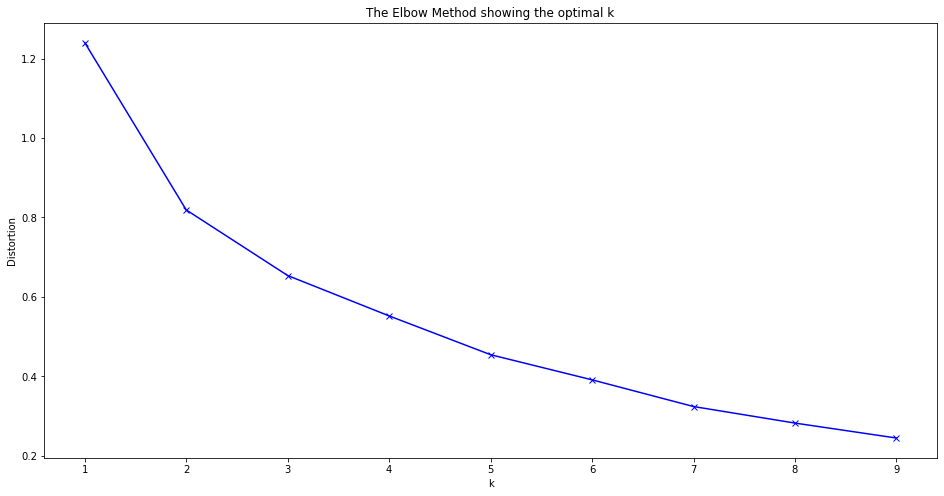

In [37]:
# Determining which k value would be best using the elbow method...

import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans

paris_grouped_clustering = paris_grouped.drop('Ardt', 1)


distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(paris_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

#Plotting the distortions of K-Means
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt

Even though it is so clear, the above plot suggests that k should be 2 or 3.

In order to get more granularity we will use ```kclusters = 3```

In [38]:
from sklearn.cluster import KMeans

kclusters = 3
paris_grouped_clustering = paris_grouped.drop('Ardt', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_venues_sorted['Ardt'] = neighborhoods_venues_sorted['Ardt'].astype('int')
paris_ardt_df['Ardt'] = paris_ardt_df['Ardt'].astype('int')

paris_merged = pd.merge(paris_ardt_df,neighborhoods_venues_sorted,on='Ardt')

In [39]:
import folium
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors


latitude = 48.856578
longitude = 2.351828

# creating a map of Toronto using latitude and longitude values
map_clusters_paris = folium.Map(location=[latitude, longitude], zoom_start=12)


map_clusters_paris.choropleth(geo_data = geo,key_on = "feature.properties.c_ar",data=paris_merged,
                 columns = ['Ardt','Cluster Labels'],fill_color='RdYlBu',fill_opacity=0.7)

for lat, lng, label in zip(far_def['Venue Latitude'], far_def['Venue Longitude'], far_def['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='green',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters_paris)

map_clusters_paris.choropleth(geo_data = geo,key_on = "feature.properties.c_ar",data=it_deficit[it_deficit['deficit']==1], columns = ['Ardt','deficit'],fill_color='Greys',fill_opacity=0.4)


#HeatMap(french_coord, gradient = french_grad).add_to(map_clusters_paris)

# adding markers to map

map_clusters_paris

Colors are for clusters, and darker areas are for areas with deficit.

In [40]:
# Analysing the characteristics of the different clusters
paris_merged.groupby('Cluster Labels').agg(lambda x:x.value_counts().index[0]).iloc[:,3:13]

lat_radians_A  long_radians_A 1st Most Common Venue  \
Cluster Labels                                                        
0                    0.853336        0.041202     French Restaurant   
1                    0.852420        0.039724     French Restaurant   
2                    0.852701        0.040355     French Restaurant   

               2nd Most Common Venue 3rd Most Common Venue  \
Cluster Labels                                               
0                Japanese Restaurant    Italian Restaurant   
1                 Italian Restaurant   Japanese Restaurant   
2                Japanese Restaurant      Greek Restaurant   

               4th Most Common Venue 5th Most Common Venue  \
Cluster Labels                                               
0                 Chinese Restaurant           Unspecified   
1                 Italian Restaurant    Seafood Restaurant   
2                 Italian Restaurant    Chinese Restaurant   

               6th Most Common Venue 7th Most Common Venue  \
Cluster Labels                                               
0                   Asian Restaurant    Italian Restaurant   
1                Moroccan Restaurant     Korean Restaurant   
2                  Indian Restaurant  Fast Food Restaurant   

               8th Most Common Venue  
Cluster Labels                        
0                 Seafood Restaurant  
1                 Seafood Restaurant  
2                 Falafel Restaurant

Right, so what can we infer from the above information?

Based on the above, we can see that most of the neighborhood in cluster 0 do not have a deficit in italian restaurants: indeed, only 2 locations kept in ```far_def``` are in cluster 0
>> We will therefore <b>exclude</b> ```Cluster 0```

Most of the venues we kept in ```far_def``` are in Cluster 1:
 >> We will therefore <b>keep</b> ```Cluster 1```


But what about Cluster 2, which is only composed of the 7th Arrondissement? 

Let's go back to ```ardt_type_df```...


In [41]:
ardt_type_df.sort_values('it/fr',ignore_index=True).head()

Ardt  nb_fr  nb_it  nb_tot    pct_fr    pct_it     it/fr
0     7     17      1      20  0.850000  0.050000  0.058824
1    15     21      2      43  0.488372  0.046512  0.095238
2    10      7      1      34  0.205882  0.029412  0.142857
3    11     12      2      25  0.480000  0.080000  0.166667
4    13      5      1      39  0.128205  0.025641  0.200000

What does it tell us?

Well, we can see that the number of italian/french restaurants is abnormally low, and that the % of french restaurants there is abnormally high! Indeed, this neighborhood was excluded from our regression analysis as we considered that it was an outlier...

This 'abnormality' can be easily explained though, with the help of Wikipedia:

> <i> The 7th arrondissement (...) includes some of the major and well-known tourist attractions of Paris, such as the Eiffel Tower, the Hôtel des Invalides (Napoleon's resting place), the Chapel of Our Lady of the Miraculous Medal, and a concentration of such world-famous museums as the Musée d'Orsay, Musée Rodin, and the Musée du quai Branly. </i> 



So as a consequence:
>> We will therefore <b>exclude</b> ```Cluster 2```


So we are only left with ```Cluster 1```

Let's add it as a filter to our density map!

In [42]:
# Creating a new curated dataframe
ardt_def_it_clust = paris_merged[paris_merged['Cluster Labels']==1]['Ardt'].values.tolist()
far_def_clust = far_def[far_def['Ardt'].isin(ardt_def_it_clust)]

In [43]:
# Plotting the best locations (far + deficit + cluster)

map_best_far_def_clust= folium.Map(location=[latitude, longitude], zoom_start=12)

french_coord = []
for index, row in far_def_clust.iterrows():
    french_coord.append([row[1], row[2]])

french_grad = {0.01: 'green', 1: 'green'}
italian_grad = {0.01: 'red', 1: 'red'}

HeatMap(french_coord, gradient = french_grad).add_to(map_best_far_def_clust)
map_best_far_def_clust.choropleth(geo_data = geo,fill_opacity=0)

for lat, lng, label in zip(far_def_clust['Venue Latitude'], far_def_clust['Venue Longitude'], far_def_clust['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='green',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_best_far_def_clust)  
 

for arr in geo["features"]:
    prop = arr["properties"]
    folium.CircleMarker(prop["geom_x_y"], radius=1, color = 'black', popup = prop["l_ar"]).add_to(map_best_far_def_clust)

map_best_far_def_clust

Getting there ! 

Let's add a last condition before we conclude: 
- we will count the number of french restaurants for each neighborhood
- we will then exclude the ones that have the smallest number of french restaurants 

In [44]:
last_ardt = far_def_clust.groupby('Ardt').count()[['Venue']].sort_values('Venue',ascending=False)
last_ardt

Venue
Ardt       
15        5
12        2
19        2
9         1
20        1

In [45]:
avg_nb_fr = last_ardt.mean().values[0]

print('The average number of remaining french restaurant in neighborhoods that could potentially welcome a new italian restaurant is '+str(avg_nb_fr))

The average number of remaining french restaurant in neighborhoods that could potentially welcome a new italian restaurant is 2.2


Let's keep only the neighborhoods above average:

In [46]:
last_ardt[last_ardt['Venue']>=avg_nb_fr]

Venue
Ardt       
15        5

So our winner is the 15th Arrondissement!

In [47]:
# Plotting the best locations (far + deficit + cluster)

winning_ardt = last_ardt[last_ardt['Venue']>=avg_nb_fr].index.tolist()
far_def_clust_15 = far_def_clust[far_def_clust['Ardt'].isin(winning_ardt)]

latitude = paris_ardt_df[paris_ardt_df['Ardt'].isin(winning_ardt)]['Latitude'].values[0]
longitude = paris_ardt_df[paris_ardt_df['Ardt'].isin(winning_ardt)]['Longitude'].values[0]

map_15= folium.Map(location=[latitude, longitude], zoom_start=14)

map_15.choropleth(geo_data = geo,fill_opacity=0)

for lat, lng, label in zip(far_def_clust_15['Venue Latitude'], far_def_clust_15['Venue Longitude'], far_def_clust_15['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=50,
        popup=label,
        color='green',
        fill=True,
        fill_opacity=0.2,
        parse_html=False).add_to(map_15)  
 

folium.CircleMarker(
        [latitude, longitude],
        radius=2,
        color='black',
        parse_html=False).add_to(map_15)

map_15

In [48]:
# Saving our results in a news dataframe
Areas_to_consider = far_def_clust_15.reset_index().drop(['index','Venue','Venue Category','code',"Ardt"],axis=1).rename(columns={"Venue Latitude": "Latitude", "Venue Longitude": "Longitude"})

*******
## Results & Discussion <a name="results"></a>

The following tables indicates the centers of areas that would be great to open an italian restaurant:

In [49]:
Areas_to_consider

Latitude  Longitude
0  48.847327   2.298303
1  48.841616   2.277794
2  48.842948   2.275587
3  48.841975   2.309041
4  48.838920   2.309052

Of course, these results are only as good as our assumptions - and they might also vary if we were to use another, richer dataset.

Also, it is important to note that decisions were made along the way, based on my (subjective) interpretation of the results: for example so one could decide to keep a cluster that I have excluded, or analyse other categories of restaurants.

The code in this notebook however is intended to be as flexible as possible and was written to work with as many inputs as possible. As a consequence, the changes one could make in these lines, should be reflected in the results.

*******
## Conclusions <a name="conclusions"></a>

In this project, we have:
- Confirmed that Italian restaurants were the most popular in Paris after French restaurants
- Confirmed that there is a positive correlation between the number of french and italian restaurants for a given neighborhood
- Identified areas where there is a <i>deficit</i> of italian restaurants relative to the number of French restaurants
- Isolated the areas with a high concentration of french restaurants while maximizing their distance to italian ones
- Identified clusters using K-means and excluded the ones that do not have the right characteristics
- Super-imposed all the analyses to come up with a limited number of results.
- Obtained the coordinates of 5 points around which it would be interesting to further investigate

We've decided to carry several analyses before concluding anything as one dimension of the data can almost never be sufficient on its own, and one should not forget that we have only taken into account a few variables: by cross checking different technical analyses, we increase the likelihood of getting to accurate conclusions.

For a final decision to be made, it would be interesting to add other datasets to this study, such as the average price per $m^2$ for each neighborhood, demographics, etc. but also, more importantly, to actually go on site to find out what it's like in real life.

We've shown that with only a small dataset, one could already have a pretty good idea of what's going in a specific area, and target only a handful of locations for further investigations.

These could lead to conclusions that exactly match the ones above, or shed light on something that had been completely missed, but in any case, a study of the available data can almost always teach us something we didn't know.